In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import os
import pickle
from glob import glob
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score, GridSearchCV
from gensim.models import Word2Vec, Doc2Vec
# import tensorflow as tf

from Doc2Vec import Doc2Vec, GensimSVMSklearn
from Constants import SENTIMENTS, TRAINING_DATA, TESTING_DATA

/Users/alanclark/.pyenv/versions/3.8.11/envs/mlmi13/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
plt.rc('font', size=16) 

In [5]:
plot_dir = 'plots'

In [6]:
pickle_dir = os.path.join('d2v_models', '041221.1')
pickle_dir

'd2v_models/041221.1'

# Data Load

In [7]:
#####################
# Original review data
#####################
og_base_dir = os.path.join('data', 'reviews')
og_pos_dir = os.path.join(og_base_dir, 'POS')
og_neg_dir = os.path.join(og_base_dir, 'NEG')

og_training_pos_files = glob(os.path.join(og_pos_dir, 'cv[0-8]*.txt'))
og_training_neg_files = glob(os.path.join(og_neg_dir, 'cv[0-8]*.txt'))

og_testing_pos_files = glob(os.path.join(og_pos_dir, 'cv9*.txt'))
og_testing_neg_files = glob(os.path.join(og_neg_dir, 'cv9*.txt'))

og_y_train = np.array([
    *[SENTIMENTS.pos.review_label]*len(og_training_pos_files),
    *[SENTIMENTS.neg.review_label]*len(og_training_neg_files)
])
og_y_test = np.array([
    *[SENTIMENTS.pos.review_label]*len(og_testing_pos_files),
    *[SENTIMENTS.neg.review_label]*len(og_testing_neg_files)
])

# d2v_training_files = [
#     *training_pos_files,
#     *training_neg_files,
#     *testing_pos_files,
#     *testing_neg_files
# ]
# d2v_testing_files = []

# gensim_sklearn = GensimSVMSklearn(
#     d2v_training_files=d2v_training_files,
#     d2v_epochs=100,
#     d2v_infer_epochs=50,
#     d2v_min_count=5,
#     d2v_vector_size=50,
#     d2v_window=5,
#     d2v_dm=0,
#     d2v_dm_concat=0,
#     d2v_dbow_words=1
# )

In [8]:
###########
# IMDB data
###########
imdb_base_dir = 'imdb'
imdb_pos_dir = 'pos'
imdb_neg_dir = 'neg'
imdb_unsup_dir = 'unsup'

imdb_train_dir = os.path.join(imdb_base_dir, 'train')
imdb_train_pos_dir = os.path.join(imdb_train_dir, imdb_pos_dir)
imdb_train_neg_dir = os.path.join(imdb_train_dir, imdb_neg_dir)

imdb_test_dir = os.path.join(imdb_base_dir, 'test')
imdb_test_pos_dir = os.path.join(imdb_test_dir, imdb_pos_dir)
imdb_test_neg_dir = os.path.join(imdb_test_dir, imdb_neg_dir)

imdb_training_pos_files = glob(os.path.join(imdb_train_pos_dir, '*.txt'))
imdb_training_neg_files = glob(os.path.join(imdb_train_neg_dir, '*.txt'))
imdb_training_files = [*imdb_training_pos_files, *imdb_training_neg_files]

imdb_testing_pos_files = glob(os.path.join(imdb_test_pos_dir, '*.txt'))
imdb_testing_neg_files = glob(os.path.join(imdb_test_neg_dir, '*.txt'))
imdb_testing_files = [*imdb_testing_pos_files, *imdb_testing_neg_files]

imdb_train_test_files = [*imdb_training_files, *imdb_testing_files]

imdb_unsup_files = glob(os.path.join(imdb_base_dir, imdb_train_dir, imdb_unsup_dir, '*.txt'))

imdb_y_train = np.array([
    *[SENTIMENTS.pos.review_label]*len(imdb_training_pos_files),
    *[SENTIMENTS.neg.review_label]*len(imdb_training_neg_files)
])
imdb_y_test = np.array([
    *[SENTIMENTS.pos.review_label]*len(imdb_testing_pos_files),
    *[SENTIMENTS.neg.review_label]*len(imdb_testing_neg_files)
])

d2v_training_files = [
    *imdb_training_pos_files,
    *imdb_training_neg_files,
    *imdb_testing_pos_files,
    *imdb_testing_neg_files,
    *imdb_unsup_files
]
d2v_testing_files = []

# Sklearn Pipeline with Gensim

Learns embeddings and then trains a SVM classifier.

## Load Previous Results

In [9]:
# with open(os.path.join(pickle_dir, 'd2v_imdb.pkl'), 'rb') as f:
    # gensim_sklearn = pickle.load(f)

## Train New

In [10]:
gensim_sklearn = GensimSVMSklearn(
    d2v_training_files=d2v_training_files,
    d2v_epochs=100,
    d2v_infer_epochs=100,
    d2v_min_count=5,
    d2v_vector_size=200,
    d2v_window=5,
    d2v_dm=0,
    d2v_dm_concat=0,
    d2v_dbow_words=1
)

In [11]:
gensim_sklearn.train([*og_training_pos_files, *og_training_neg_files], og_y_train)

2021-12-04 12:07:34,980 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec(dbow+w,d200,n5,w5,mc5,s0.001,t4)', 'datetime': '2021-12-04T12:07:34.980452', 'gensim': '4.1.2', 'python': '3.8.11 (default, Aug  8 2021, 15:14:31) \n[Clang 12.0.5 (clang-1205.0.22.9)]', 'platform': 'macOS-12.0.1-x86_64-i386-64bit', 'event': 'created'}
2021-12-04 12:07:34,981 : INFO : collecting all words and their counts
2021-12-04 12:07:34,981 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-12-04 12:07:35,553 : INFO : PROGRESS: at example #10000, processed 2284666 words (4005297/s), 50183 word types, 10000 tags
2021-12-04 12:07:35,913 : INFO : PROGRESS: at example #20000, processed 4536106 words (6251641/s), 67179 word types, 20000 tags
2021-12-04 12:07:36,268 : INFO : PROGRESS: at example #30000, processed 6739502 words (6222870/s), 80431 word types, 28600 tags
2021-12-04 12:07:36,634 : INFO : PROGRESS: at example #40000, processed 8970937 words (6111845/s), 90945 word ty

[Pipeline] ........... (step 1 of 2) Processing doc2vec, total=41.6min
[Pipeline] ............... (step 2 of 2) Processing svc, total=   0.2s


In [12]:
gensim_sklearn.test([*og_training_pos_files, *og_training_neg_files], og_y_train)

0.9711111111111111


In [13]:
gensim_sklearn.test([*og_testing_pos_files, *og_testing_neg_files], og_y_test)

0.9


## Save Model

Save the Gensim sklearn pickle

In [14]:
# with open(os.path.join(pickle_dir, 'd2v_imdb.pkl'), 'wb') as f:
#     pickle.dump(gensim_sklearn, f)

In [15]:
# gensim_sklearn.pipeline.named_steps['doc2vec'].model.save(os.path.join(pickle_dir, 'd2v_imdb.gensim'))

2021-12-04 12:51:04,012 : INFO : Doc2Vec lifecycle event {'fname_or_handle': 'd2v_models/041221.1/d2v_imdb.gensim', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-12-04T12:51:04.012153', 'gensim': '4.1.2', 'python': '3.8.11 (default, Aug  8 2021, 15:14:31) \n[Clang 12.0.5 (clang-1205.0.22.9)]', 'platform': 'macOS-12.0.1-x86_64-i386-64bit', 'event': 'saving'}
2021-12-04 12:51:04,013 : INFO : not storing attribute cum_table
2021-12-04 12:51:04,101 : INFO : saved d2v_models/041221.1/d2v_imdb.gensim


## Cross Validation

In [16]:
# gensim_sklearn.cross_validate([*training_pos_files, *training_neg_files], y_train, folds=10)

## Grid Search

In [17]:
# gs_params = {
#     'doc2vec__epochs': (100,),
#     'doc2vec__infer_epochs': (50,),
#     'doc2vec__vector_size': (50,100,200), 
#     'doc2vec__dm': (0,1),
#     'doc2vec__dm_concat': (0,1),
#     'doc2vec__dbow_words': (1,),
#     'doc2vec__window': (5,10,15),
#     'doc2vec__min_count': (5,)
# }
# gensim_sklearn = GensimSVMSklearn(d2v_training_files=d2v_training_files)
# gensim_sklearn.grid_search([*training_pos_files, *training_neg_files], y_train, gs_params)

In [18]:
# pd.DataFrame(gensim_sklearn.gs.cv_results_).to_json()

In [19]:
# gensim_sklearn.gs.best_params_

In [20]:
# gensim_sklearn.gs.best_score_

In [21]:
# gensim_sklearn.pipeline.named_steps['doc2vec'].model.save('doc2vec_model.gensim')

Open a pre-saved CV model and save the results to a csv

In [22]:
# with open('d2v_gs/d2v_gs_sc_sc_epoch_vs_search.pkl', 'rb') as f:
#     d2v_gs = pickle.load(f)

In [23]:
# pd.DataFrame(d2v_gs.gs.cv_results_).to_csv('d2v_gs/d2v_gs_sc_sc_epoch_vs_search_results.csv')

# Generate Embeddings

In [24]:
# og_training_pos_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(og_training_pos_files)
# og_training_neg_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(og_training_neg_files)
# og_testing_pos_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(og_testing_pos_files)
# og_testing_neg_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(og_testing_neg_files)

In [25]:
# og_training_pos_embeddings = np.load(os.path.join(pickle_dir, 'og_training_pos_embeddings.npy'))
# og_training_neg_embeddings = np.load(os.path.join(pickle_dir, 'og_training_neg_embeddings.npy'))
# og_testing_pos_embeddings = np.load(os.path.join(pickle_dir, 'og_testing_pos_embeddings.npy'))
# og_testing_neg_embeddings = np.load(os.path.join(pickle_dir, 'og_testing_neg_embeddings.npy'))

In [26]:
# np.save(os.path.join(pickle_dir, 'og_training_pos_embeddings.npy'), og_training_pos_embeddings)
# np.save(os.path.join(pickle_dir, 'og_training_neg_embeddings.npy'), og_training_neg_embeddings)
# np.save(os.path.join(pickle_dir, 'og_testing_pos_embeddings.npy'), og_testing_pos_embeddings)
# np.save(os.path.join(pickle_dir, 'og_testing_neg_embeddings.npy'), og_testing_neg_embeddings)

In [27]:
og_X_train = np.vstack((og_training_pos_embeddings, og_training_neg_embeddings))
og_X_test = np.vstack((og_testing_pos_embeddings, og_testing_neg_embeddings))
og_X_train.shape, og_X_test.shape

((1800, 200), (200, 200))

In [28]:
# imdb_training_pos_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(imdb_training_pos_files)
# imdb_training_neg_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(imdb_training_neg_files)
# imdb_testing_pos_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(imdb_testing_pos_files)
# imdb_testing_neg_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(imdb_testing_neg_files)

In [29]:
# np.save(os.path.join(pickle_dir, 'imdb_training_pos_embeddings.npy'), imdb_training_pos_embeddings)
# np.save(os.path.join(pickle_dir, 'imdb_training_neg_embeddings.npy'), imdb_training_neg_embeddings)
# np.save(os.path.join(pickle_dir, 'imdb_testing_pos_embeddings.npy'), imdb_testing_pos_embeddings)
# np.save(os.path.join(pickle_dir, 'imdb_testing_neg_embeddings.npy'), imdb_testing_neg_embeddings)

In [30]:
imdb_X_train = np.vstack((imdb_training_pos_embeddings, imdb_training_neg_embeddings))
imdb_X_test = np.vstack((imdb_testing_pos_embeddings, imdb_testing_neg_embeddings))
imdb_X_train.shape, imdb_X_test.shape

((25000, 200), (25000, 200))

# SVC

## OG Data

In [40]:
logger.info('Training SVM with embeddings')
svm = SVC()
svm.fit(og_X_train, og_y_train)

2021-12-04 13:18:01,503 : INFO : Training SVM with embeddings


SVC()

In [41]:
logger.info('Testing SVM with embeddings')
# svm.cross_validate(og_X_train, og_y_train, folds=10)
og_train_predict = svm.predict(og_X_train)
og_test_predict = svm.predict(og_X_test)

2021-12-04 13:18:01,801 : INFO : Testing SVM with embeddings


In [42]:
svm.score(og_X_train, og_y_train), svm.score(og_X_test, og_y_test)

(0.9722222222222222, 0.89)

In [46]:
d2v_svc_cv_scores = cross_val_score(svm, og_X_train, og_y_train, cv=10)
d2v_svc_cv_scores, d2v_svc_cv_scores.mean(), d2v_svc_cv_scores.std()

(array([0.89444444, 0.87777778, 0.85555556, 0.87222222, 0.85555556,
        0.9       , 0.88333333, 0.86666667, 0.86666667, 0.86666667]),
 0.8738888888888889,
 0.014283289035758283)

In [35]:
svm_gs_params = {
    "C": np.arange(0.2, 10.2, 0.4),
    "kernel": ["linear", "poly", "rbf", "sigmoid"]
}
grid_search = GridSearchCV(SVC(), svm_gs_params, n_jobs=-1, cv=10)
grid_search.fit(og_X_train, og_y_train)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([0.2, 0.6, 1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ,
       5.4, 5.8, 6.2, 6.6, 7. , 7.4, 7.8, 8.2, 8.6, 9. , 9.4, 9.8]),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [47]:
grid_search.best_score_, grid_search.best_params_

(0.8833333333333334, {'C': 1.8000000000000003, 'kernel': 'rbf'})

In [48]:
svm = SVC(**grid_search.best_params_)
svm.fit(og_X_train, og_y_train)
svm.score(og_X_train, og_y_train), svm.score(og_X_test, og_y_test)

(0.9866666666666667, 0.905)

In [49]:
d2v_svc_cv_scores = cross_val_score(svm, og_X_train, og_y_train, cv=10)
d2v_svc_cv_scores, d2v_svc_cv_scores.mean(), d2v_svc_cv_scores.std()

(array([0.89444444, 0.88333333, 0.86111111, 0.88333333, 0.87777778,
        0.9       , 0.9       , 0.86666667, 0.87777778, 0.88888889]),
 0.8833333333333334,
 0.012422599874998826)

## IMDB Data

In [50]:
logger.info('Training SVM with embeddings')
svm = SVC()
svm.fit(imdb_X_train, imdb_y_train)

2021-12-04 13:21:19,062 : INFO : Training SVM with embeddings


SVC()

In [51]:
logger.info('Testing SVM with embeddings')
imdb_train_predict = svm.predict(imdb_X_train)
imdb_test_predict = svm.predict(imdb_X_test)

2021-12-04 13:22:45,737 : INFO : Testing SVM with embeddings


In [52]:
imdb_train_predict_results = imdb_train_predict == imdb_y_train
imdb_test_predict_results = imdb_test_predict == imdb_y_test
imdb_predict_results = np.hstack((imdb_train_predict_results, imdb_test_predict_results))
imdb_predict_results.shape

(50000,)

In [53]:
svm.score(imdb_X_train, imdb_y_train), svm.score(imdb_X_test, imdb_y_test)

(0.96676, 0.86956)

In [54]:
d2v_svc_cv_scores = cross_val_score(svm, imdb_X_train, imdb_y_train, cv=10)
d2v_svc_cv_scores, d2v_svc_cv_scores.mean(), d2v_svc_cv_scores.std()

array([0.892 , 0.91  , 0.9128, 0.9096, 0.9076, 0.904 , 0.9024, 0.9108,
       0.904 , 0.9008])

In [55]:
svm_gs_params = {
    "C": np.arange(0.2, 10.2, 0.4),
    "kernel": ["linear", "poly", "rbf", "sigmoid"]
}
grid_search = GridSearchCV(SVC(), svm_gs_params, n_jobs=-1, cv=10)
grid_search.fit(imdb_X_train, imdb_y_train)

KeyboardInterrupt: 

In [ ]:
grid_search.best_score_, grid_search.best_params_

(0.8833333333333334, {'C': 1.8000000000000003, 'kernel': 'rbf'})

In [ ]:
svm = SVC(**grid_search.best_params_)
svm.fit(imdb_X_train, imdb_y_train)
svm.score(imdb_X_train, imdb_y_train), svm.score(imdb_X_test, imdb_y_test)

(0.9866666666666667, 0.905)

In [ ]:
d2v_svc_cv_scores = cross_val_score(svm, imdb_X_train, imdb_y_train, cv=10)
d2v_svc_cv_scores, d2v_svc_cv_scores.mean(), d2v_svc_cv_scores.std()

(array([0.89444444, 0.88333333, 0.86111111, 0.88333333, 0.87777778,
        0.9       , 0.9       , 0.86666667, 0.87777778, 0.88888889]),
 0.8833333333333334,
 0.012422599874998826)

## Gensim Learnt Word Embeddings

In [56]:
gensim_vectors = np.asarray(gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.vectors)
gensim_labels = np.asarray(gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.index_to_key)
gensim_vectors.shape, gensim_labels.shape

((39191, 200), (39191,))

In [90]:
gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar('awful')

[('terrible', 0.8062343597412109),
 ('horrible', 0.7477142214775085),
 ('bad', 0.697106122970581),
 ('dreadful', 0.679743230342865),
 ('atrocious', 0.6529355049133301),
 ('ridiculous', 0.650322437286377),
 ('horrendous', 0.6332698464393616),
 ('stupid', 0.6267639398574829),
 ('lousy', 0.6099908947944641),
 ('horrid', 0.5949856042861938)]

Use this to generate embeddings to use in Tensorflow

In [61]:
# gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.save_word2vec_format(os.path.join(pickle_dir, 'gensim_word_embeddings.gensim'))

In [62]:
# !python -m gensim.scripts.word2vec2tensor -i gensim_word_embeddings.gensim -o gensim_word_embeddings.tsv

# Existing Word Embeddings

In [63]:
# wiki_sg = Doc2Vec.load(os.path.join('wiki_sg', 'word2vec.bin'))
# wiki_sg

# Lexicon Data

In [64]:
lexicon_dict = {}
with open('data/sent_lexicon', 'r') as f:
    for line in f:
        word = line.split()[2].split("=")[1]
        polarity = line.split()[5].split("=")[1]
        magnitude = line.split()[0].split("=")[1]
        lexicon_dict[word] = [magnitude, polarity]
lexicon_pos_words = [w for w,t in lexicon_dict.items() if t[1] == 'positive' and t[0] == 'strongsubj' and w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]
lexicon_neg_words = [w for w,t in lexicon_dict.items() if t[1] == 'negative' and t[0] == 'strongsubj' and w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]
# lexicon_pos_words = [w for w,t in lexicon_dict.items() if t[1] == 'positive' and w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]
# lexicon_neg_words = [w for w,t in lexicon_dict.items() if t[1] == 'negative' and w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]

good_words = ['good', *[i[0] for i in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar('good')]]
bad_words = ['bad', *[i[0] for i in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar('bad')]]

wonderful_words = ['wonderful', *[i[0] for i in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar('wonderful')]]
awful_words = ['awful', *[i[0] for i in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar('awful')]]

In [65]:
# General positive and negative indices
pos_inds = np.where(np.isin(gensim_labels,lexicon_pos_words))[0]
neg_inds = np.where(np.isin(gensim_labels,lexicon_neg_words))[0]

# Weakly positive and negative words
good_inds = np.where(np.isin(gensim_labels, good_words))[0]
bad_inds = np.where(np.isin(gensim_labels, bad_words))[0]

# Strongly positive and negative words
wonderful_inds = np.where(np.isin(gensim_labels, wonderful_words))[0]
awful_inds = np.where(np.isin(gensim_labels, awful_words))[0]

In [66]:
lexicon_pos_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in lexicon_pos_words])
lexicon_neg_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in lexicon_neg_words])

good_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in good_words])
bad_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in bad_words])

wonderful_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in wonderful_words])
awful_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in awful_words])

# Visualisations

In [67]:
pos_visualisation_review_paths = ['imdb/train/pos/11_9.txt', 'imdb/train/pos/16_7.txt', 'imdb/train/pos/12471_7.txt']
pos_visualisation_review_gensim_inds = np.array([np.where(np.array(imdb_train_test_files) == p)[0] for p in pos_visualisation_review_paths]).flatten()

neg_visualisation_review_paths = ['imdb/train/neg/11_3.txt', 'imdb/train/neg/16_3.txt', 'imdb/train/neg/12471_1.txt']
neg_visualisation_review_gensim_inds = np.array([np.where(np.array(imdb_train_test_files) == p)[0] for p in neg_visualisation_review_paths]).flatten()

## Gensim Instructions

In [68]:
# def reduce_dimensions(model):
#     num_dimensions = 2  # final num dimensions (2D, 3D, etc)

#     # extract the words & their vectors, as numpy arrays
#     vectors = np.asarray(model.wv.vectors)
#     labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

#     # reduce using t-SNE
#     tsne = TSNE(n_components=num_dimensions, random_state=0)
#     vectors = tsne.fit_transform(vectors)

#     x_vals = [v[0] for v in vectors]
#     y_vals = [v[1] for v in vectors]
#     return x_vals, y_vals, labels, tsne


# x_vals, y_vals, labels, tsne = reduce_dimensions(gensim_sklearn.pipeline.named_steps['doc2vec'].model)
# x_vals = np.array(x_vals)
# y_vals = np.array(y_vals)

In [69]:
def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

## TSNE

In [76]:
imdb_embeddings = np.vstack((imdb_X_train, imdb_X_test))
imdb_labels = np.hstack((imdb_y_train, imdb_y_test))

tsne_embeddings = np.vstack((gensim_vectors, imdb_embeddings))
tsne_labels = np.hstack((gensim_labels, imdb_labels))

tsne_reviews = np.hstack((np.zeros_like(gensim_labels), np.array(imdb_training_pos_files), np.array(imdb_training_neg_files), np.array(imdb_testing_pos_files), np.array(imdb_testing_neg_files)))

In [77]:
num_tsne_dimensions = 2
tsne = TSNE(n_components=num_tsne_dimensions, random_state=0, n_jobs=-1, verbose=5)
tsne_vectors = tsne.fit_transform(tsne_embeddings)

/Users/alanclark/.pyenv/versions/3.8.11/envs/mlmi13/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/alanclark/.pyenv/versions/3.8.11/envs/mlmi13/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 89191 samples in 0.014s...
[t-SNE] Computed neighbors for 89191 samples in 212.741s...
[t-SNE] Computed conditional probabilities for sample 1000 / 89191
[t-SNE] Computed conditional probabilities for sample 2000 / 89191
[t-SNE] Computed conditional probabilities for sample 3000 / 89191
[t-SNE] Computed conditional probabilities for sample 4000 / 89191
[t-SNE] Computed conditional probabilities for sample 5000 / 89191
[t-SNE] Computed conditional probabilities for sample 6000 / 89191
[t-SNE] Computed conditional probabilities for sample 7000 / 89191
[t-SNE] Computed conditional probabilities for sample 8000 / 89191
[t-SNE] Computed conditional probabilities for sample 9000 / 89191
[t-SNE] Computed conditional probabilities for sample 10000 / 89191
[t-SNE] Computed conditional probabilities for sample 11000 / 89191
[t-SNE] Computed conditional probabilities for sample 12000 / 89191
[t-SNE] Computed conditional probabilities for s

In [249]:
# with open(os.path.join(pickle_dir, 'tsne.pkl'), 'rb') as f:
#     tsne = pickle.load(f)
# tsne_vectors = np.load(os.path.join(pickle_dir, 'tsne_vectors.npy'))

In [78]:
# with open(os.path.join(pickle_dir, 'tsne.pkl'), 'wb') as f:
#     pickle.dump(tsne, f)
# np.save(os.path.join(pickle_dir, 'tsne_vectors.npy'), tsne_vectors)

In [79]:
tsne_vectors.shape, tsne_labels.shape

((89191, 2), (89191,))

In [80]:
# plot_with_plotly(tsne_vectors[:,0], tsne_vectors[:,1], labels)

In [81]:
# plot_with_matplotlib(tsne_vectors[:,0], tsne_vectors[:,1], labels)

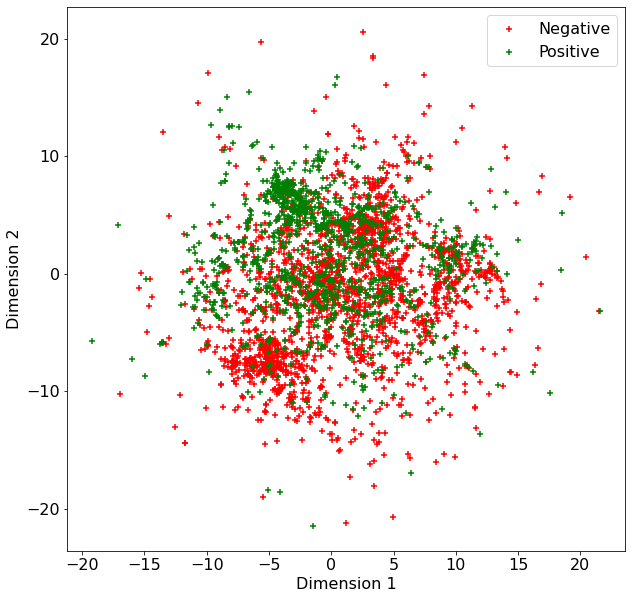

In [82]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.scatter(tsne_vectors[neg_inds,0], tsne_vectors[neg_inds,1], marker='+', c='r', label='Negative')
ax.scatter(tsne_vectors[pos_inds,0], tsne_vectors[pos_inds,1], marker='+', c='g', label='Positive')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend()

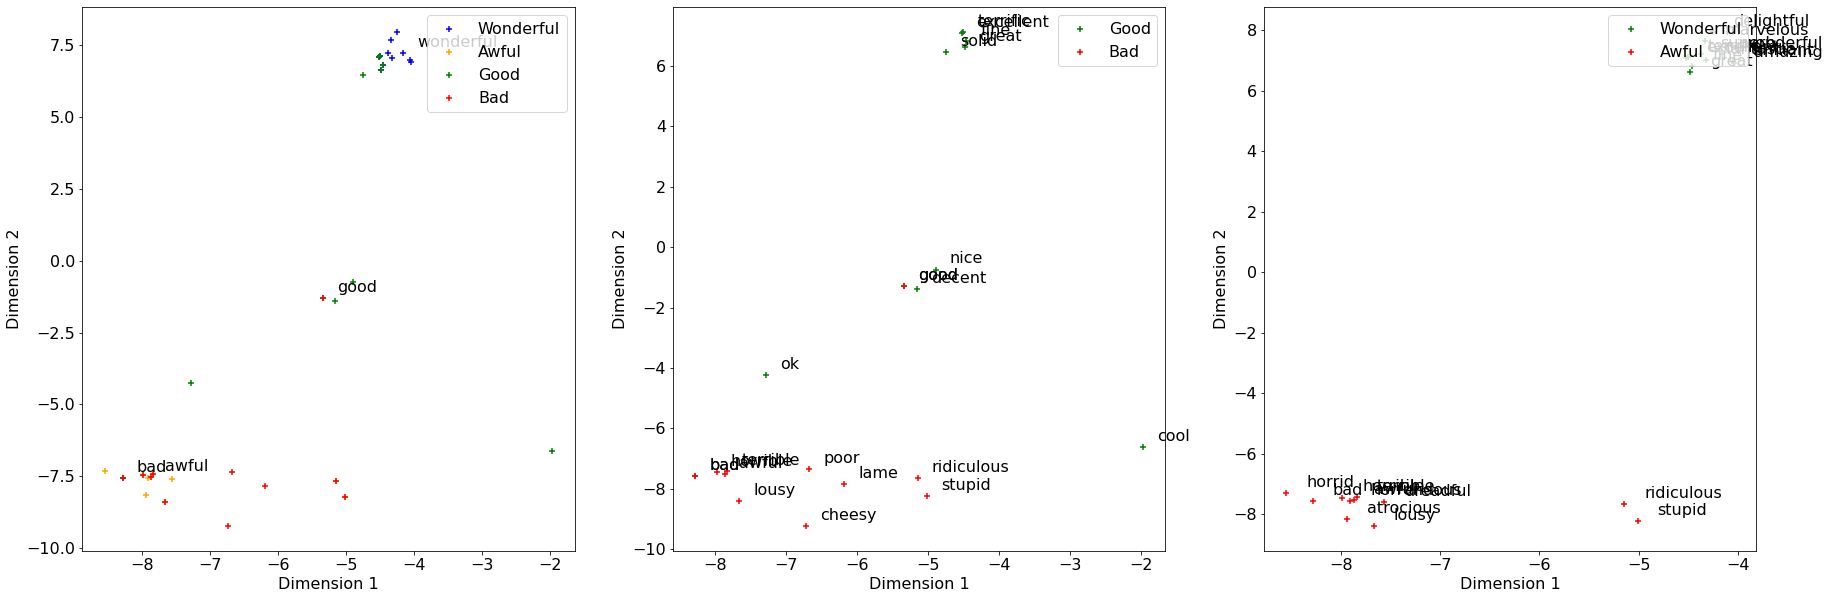

In [83]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

annotation_dist = 0.2

ax[0].scatter(tsne_vectors[wonderful_inds,0], tsne_vectors[wonderful_inds,1], marker='+', c='b', label='Wonderful')
ax[0].scatter(tsne_vectors[awful_inds,0], tsne_vectors[awful_inds,1], marker='+', c='orange', label='Awful')
ax[0].scatter(tsne_vectors[good_inds,0], tsne_vectors[good_inds,1], marker='+', c='g', label='Good')
ax[0].scatter(tsne_vectors[bad_inds,0], tsne_vectors[bad_inds,1], marker='+', c='r', label='Bad')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')
ax[0].legend(loc='upper right')
for w in ['wonderful', 'awful', 'good', 'bad']:
    label_ind = np.where(tsne_labels == w)[0]
    ax[0].annotate(tsne_labels[label_ind][0], (tsne_vectors[label_ind,0]+annotation_dist, tsne_vectors[label_ind,1]+annotation_dist))

ax[1].scatter(tsne_vectors[good_inds,0], tsne_vectors[good_inds,1], marker='+', c='g', label='Good')
ax[1].scatter(tsne_vectors[bad_inds,0], tsne_vectors[bad_inds,1], marker='+', c='r', label='Bad')
for i in good_inds:
    ax[1].annotate(tsne_labels[i], (tsne_vectors[i,0]+annotation_dist, tsne_vectors[i,1]+annotation_dist))
for i in bad_inds:
    ax[1].annotate(tsne_labels[i], (tsne_vectors[i,0]+annotation_dist, tsne_vectors[i,1]+annotation_dist))
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[1].legend(loc='upper right')

ax[2].scatter(tsne_vectors[wonderful_inds,0], tsne_vectors[wonderful_inds,1], marker='+', c='g', label='Wonderful')
ax[2].scatter(tsne_vectors[awful_inds,0], tsne_vectors[awful_inds,1], marker='+', c='r', label='Awful')
for i in wonderful_inds:
    ax[2].annotate(tsne_labels[i], (tsne_vectors[i,0]+annotation_dist, tsne_vectors[i,1]+annotation_dist))
for i in awful_inds:
    ax[2].annotate(tsne_labels[i], (tsne_vectors[i,0]+annotation_dist, tsne_vectors[i,1]+annotation_dist))
ax[2].set_xlabel('Dimension 1')
ax[2].set_ylabel('Dimension 2')
ax[2].legend(loc='upper right')

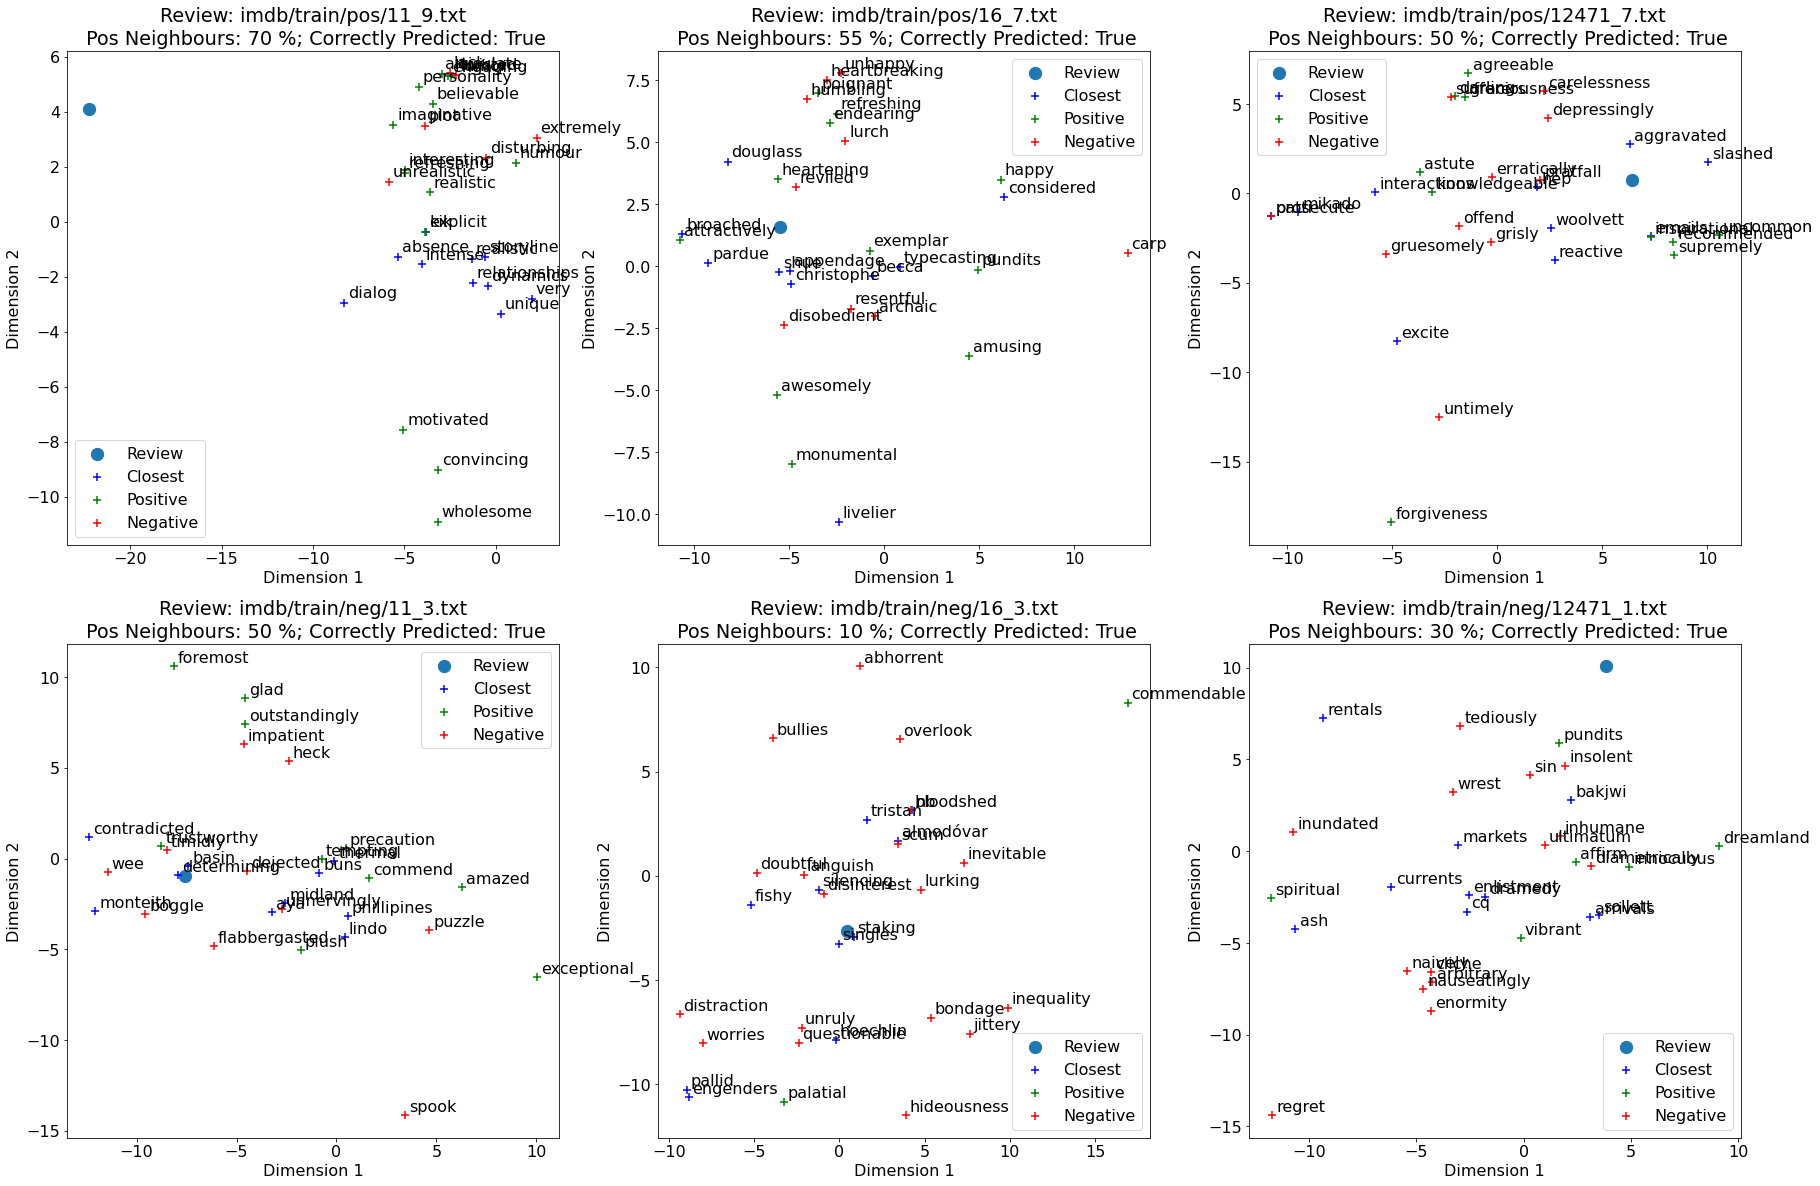

In [86]:
fig, ax = plt.subplots(2, 3, figsize=(30,20))

for i, vis_tuple in enumerate([(pos_visualisation_review_paths, pos_visualisation_review_gensim_inds), (neg_visualisation_review_paths, neg_visualisation_review_gensim_inds)]):
    visualisation_review_paths, visualisation_review_gensim_inds = vis_tuple

    for j, visualisation_review_path in enumerate(visualisation_review_paths):
        train_test_ind = visualisation_review_gensim_inds[i]
        review_pred_correct = imdb_predict_results[train_test_ind]
        
        tsne_review_ind = np.where(tsne_reviews == visualisation_review_path)
        review_embedding = gensim_sklearn.pipeline.named_steps['doc2vec'].transform([visualisation_review_path])
        review_embedding_tsne = tsne_vectors[tsne_review_ind,:][0]

        review_closest_words = [w[0] for w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar(review_embedding, topn=1000)]
        review_closest_words_mask = np.isin(tsne_labels, review_closest_words)
        review_closest_word_embeddings = tsne_vectors[review_closest_words_mask][:10,:]

        review_closest_lexicon_words = [w for w in review_closest_words if w in [*lexicon_pos_words, *lexicon_neg_words]][:20]
        review_closest_lexicon_words_mask = np.isin(tsne_labels, review_closest_lexicon_words)
        review_closest_lexicon_words_embeddings = tsne_vectors[review_closest_lexicon_words_mask]
        review_lexicon_labels = np.array([lexicon_dict[t][1] for t in review_closest_lexicon_words])

        ax[i,j].scatter(review_embedding_tsne[:,0], review_embedding_tsne[:,1], s=150, label='Review')

        ax[i,j].scatter(review_closest_word_embeddings[:,0], review_closest_word_embeddings[:,1], marker='+', s=75, c='b', label='Closest')
        for k in range(review_closest_word_embeddings.shape[0]):
            ax[i,j].annotate(review_closest_words[k], (review_closest_word_embeddings[k,0]+0.2, review_closest_word_embeddings[k,1]+0.2))

        plt_colors = {'positive':'green', 'negative':'red', 'neutral':'blue', 'both':'yellow'}
        for k in plt_colors.items():
            k_ind = np.where(review_lexicon_labels == k[0])
            if np.any(k_ind):
                ax[i,j].scatter(review_closest_lexicon_words_embeddings[k_ind,0], review_closest_lexicon_words_embeddings[k_ind,1], marker='+', s=75, c=k[1], label=k[0].title())
        for k in range(review_closest_lexicon_words_embeddings.shape[0]):
            ax[i,j].annotate(review_closest_lexicon_words[k], (review_closest_lexicon_words_embeddings[k,0]+0.2, review_closest_lexicon_words_embeddings[k,1]+0.2))

        ax[i,j].set_xlabel('Dimension 1')
        ax[i,j].set_ylabel('Dimension 2')
        ax[i,j].set_title(f'Review: {visualisation_review_path}\n Pos Neighbours: {int((review_lexicon_labels==SENTIMENTS.pos.lexicon_label).mean()*100)} %; Correctly Predicted: {review_pred_correct}')
        # ax[i].set_xlim(-1.25, 2)
        # ax[i].set_ylim(-1.25, 2)
        ax[i,j].legend()

In [85]:
gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar(review_embedding, topn=10)

[('currents', 0.3340969383716583),
 ('markets', 0.33079543709754944),
 ('enlistment', 0.32368960976600647),
 ('arrivals', 0.3224066197872162),
 ('sollett', 0.31679150462150574),
 ('financially', 0.31615057587623596),
 ('rentals', 0.31436729431152344),
 ('cq', 0.3141867220401764),
 ('ash', 0.3123842477798462),
 ('interval', 0.3088648319244385)]

## PCA

In [70]:
pca_embeddings = gensim_vectors
# pca_embeddings = np.vstack((lexicon_pos_word_embeddings, lexicon_neg_word_embeddings))

pca_2 = PCA(n_components=2)
pca_embeds_2d = pca_2.fit(pca_embeddings)
words_pca = pca_embeds_2d.transform(pca_embeddings)

# pca_3 = PCA(n_components=3)
# pca_embeds_3d = pca_3.fit(pca_embeddings)

pca_embeds_2d.explained_variance_ratio_, #pca_embeds_3d.explained_variance_ratio_

(array([0.01584795, 0.01329558], dtype=float32),)

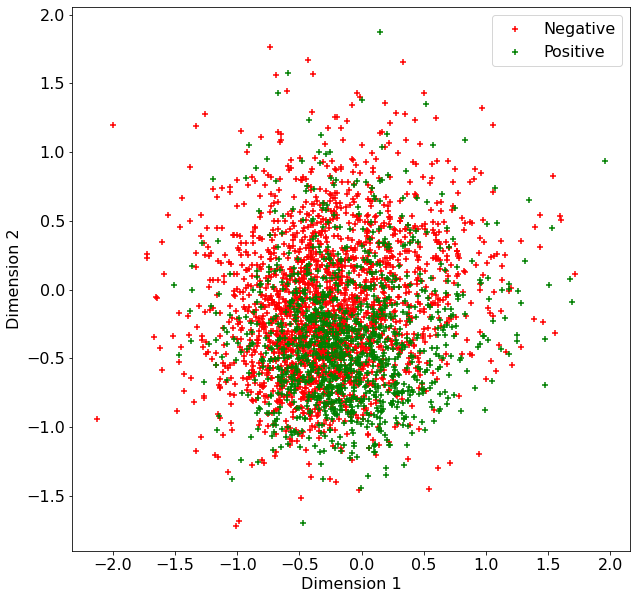

In [71]:
fig, ax = plt.subplots(1, figsize=(10,10))   
ax.scatter(words_pca[neg_inds,0], words_pca[neg_inds,1], marker='+', c='r', label=SENTIMENTS.neg.lexicon_label.title())
ax.scatter(words_pca[pos_inds,0], words_pca[pos_inds,1], marker='+', c='g', label=SENTIMENTS.pos.lexicon_label.title())
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend()

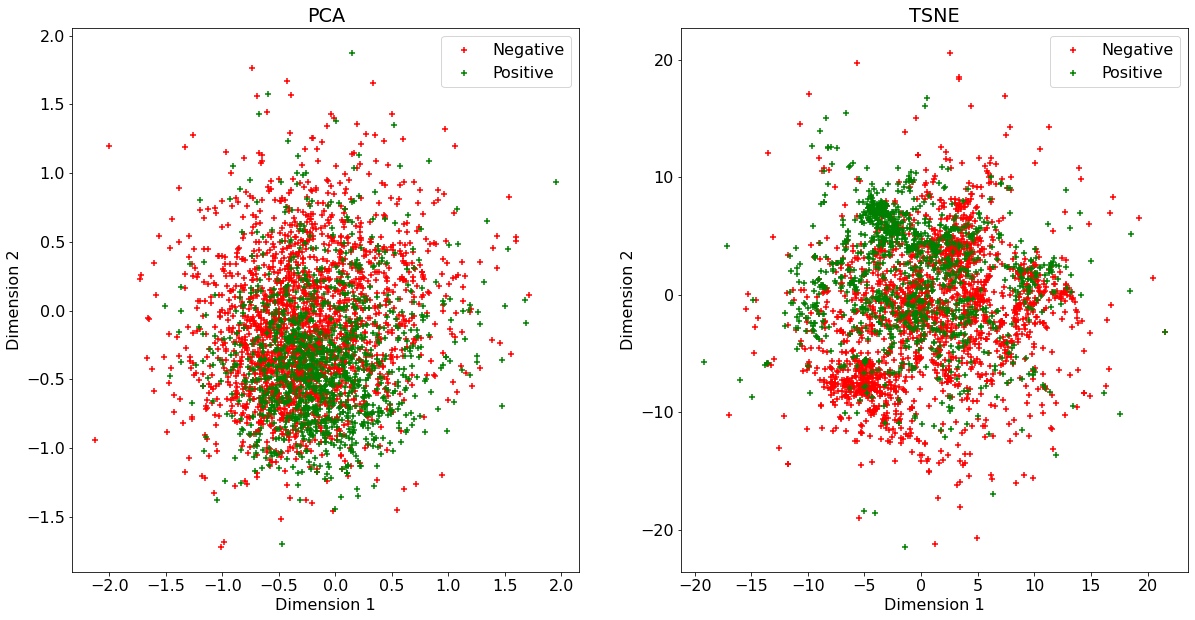

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))   

ax[0].scatter(words_pca[neg_inds,0], words_pca[neg_inds,1], marker='+', c='r', label=SENTIMENTS.neg.lexicon_label.title())
ax[0].scatter(words_pca[pos_inds,0], words_pca[pos_inds,1], marker='+', c='g', label=SENTIMENTS.pos.lexicon_label.title())
ax[0].set_title('PCA')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')
ax[0].legend()

ax[1].scatter(tsne_vectors[neg_inds,0], tsne_vectors[neg_inds,1], marker='+', c='r', label=SENTIMENTS.neg.lexicon_label.title())
ax[1].scatter(tsne_vectors[pos_inds,0], tsne_vectors[pos_inds,1], marker='+', c='g', label=SENTIMENTS.pos.lexicon_label.title())
ax[1].set_title('TSNE')
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[1].legend()

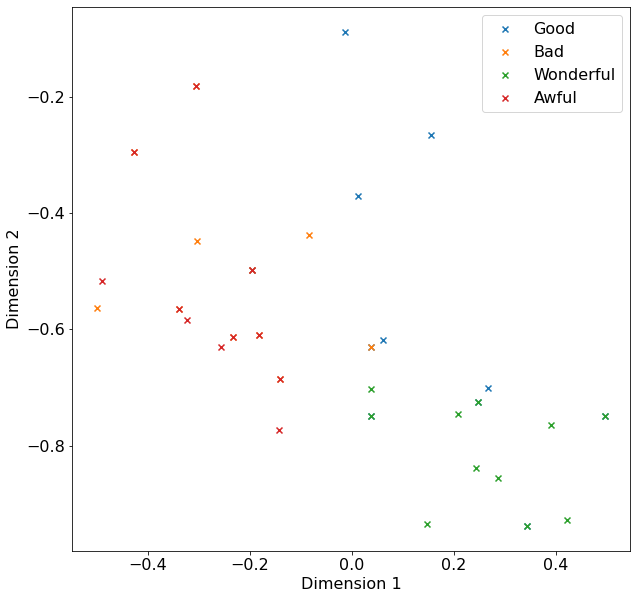

In [94]:
fig, ax = plt.subplots(1, figsize=(10,10))
for embed_tuple in [('Good', good_inds), ('Bad', bad_inds), ('Wonderful', wonderful_inds), ('Awful', awful_inds)]:
    label, inds = embed_tuple
    ax.scatter(words_pca[inds,0], words_pca[inds,1], marker='x', label=label)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend()

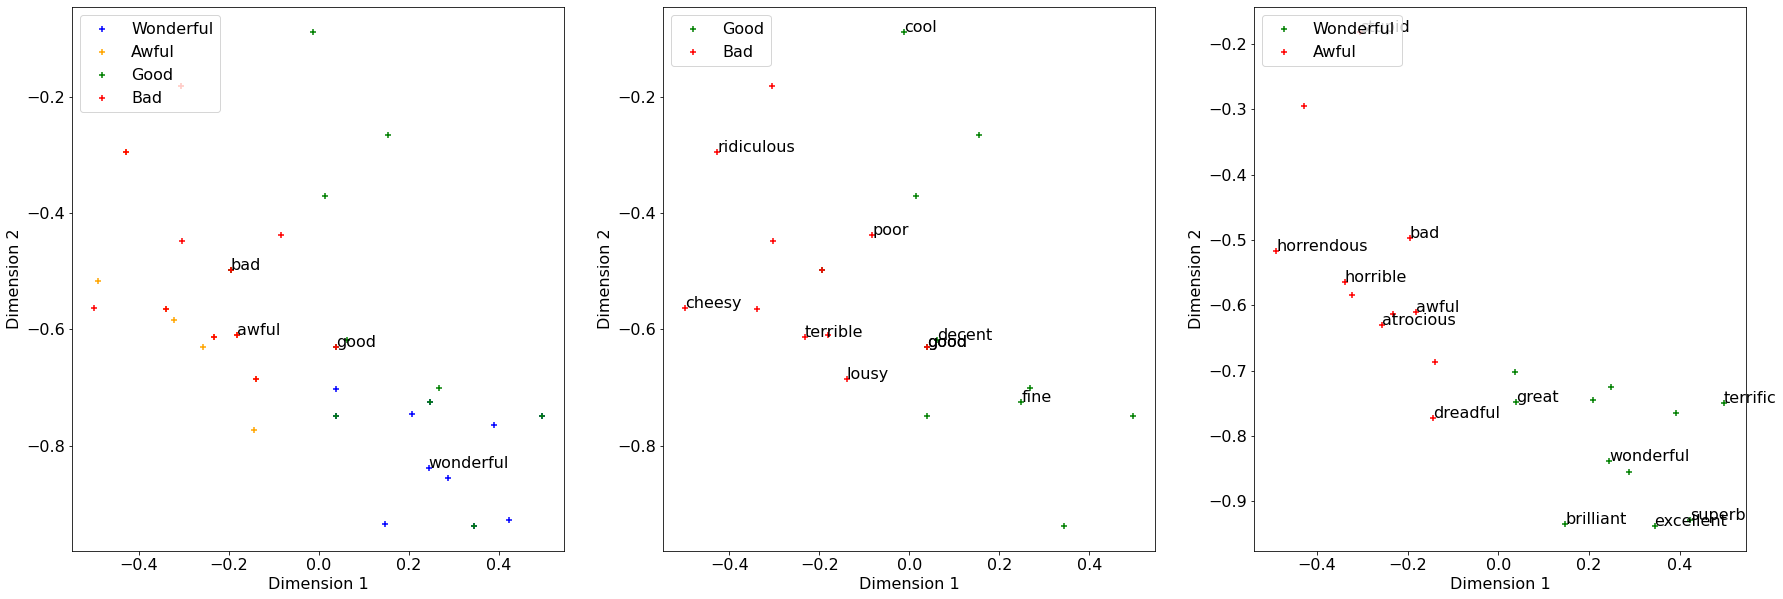

In [95]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

ax[0].scatter(words_pca[wonderful_inds,0], words_pca[wonderful_inds,1], marker='+', c='b', label='Wonderful')
ax[0].scatter(words_pca[awful_inds,0], words_pca[awful_inds,1], marker='+', c='orange', label='Awful')
ax[0].scatter(words_pca[good_inds,0], words_pca[good_inds,1], marker='+', c='g', label='Good')
ax[0].scatter(words_pca[bad_inds,0], words_pca[bad_inds,1], marker='+', c='r', label='Bad')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')
ax[0].legend(loc='upper left')
for w in ['wonderful', 'awful', 'good', 'bad']:
    label_ind = np.where(gensim_labels == w)[0]
    ax[0].annotate(gensim_labels[label_ind][0], (words_pca[label_ind,0], words_pca[label_ind,1]))

ax[1].scatter(words_pca[good_inds,0], words_pca[good_inds,1], marker='+', c='g', label='Good')
ax[1].scatter(words_pca[bad_inds,0], words_pca[bad_inds,1], marker='+', c='r', label='Bad')
for i in good_inds:
    if not i % 2:
        continue
    ax[1].annotate(gensim_labels[i], (words_pca[i,0], words_pca[i,1]))
for i in bad_inds:
    if not i % 2:
        continue
    ax[1].annotate(gensim_labels[i], (words_pca[i,0], words_pca[i,1]))
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[1].legend(loc='upper left')

ax[2].scatter(words_pca[wonderful_inds,0], words_pca[wonderful_inds,1], marker='+', c='g', label='Wonderful')
ax[2].scatter(words_pca[awful_inds,0], words_pca[awful_inds,1], marker='+', c='r', label='Awful')
for i in wonderful_inds:
    if i % 2:
        continue
    ax[2].annotate(gensim_labels[i], (words_pca[i,0], words_pca[i,1]))
for i in awful_inds:
    if i % 2:
        continue
    ax[2].annotate(gensim_labels[i], (words_pca[i,0], words_pca[i,1]))
ax[2].set_xlabel('Dimension 1')
ax[2].set_ylabel('Dimension 2')
ax[2].legend(loc='upper left')

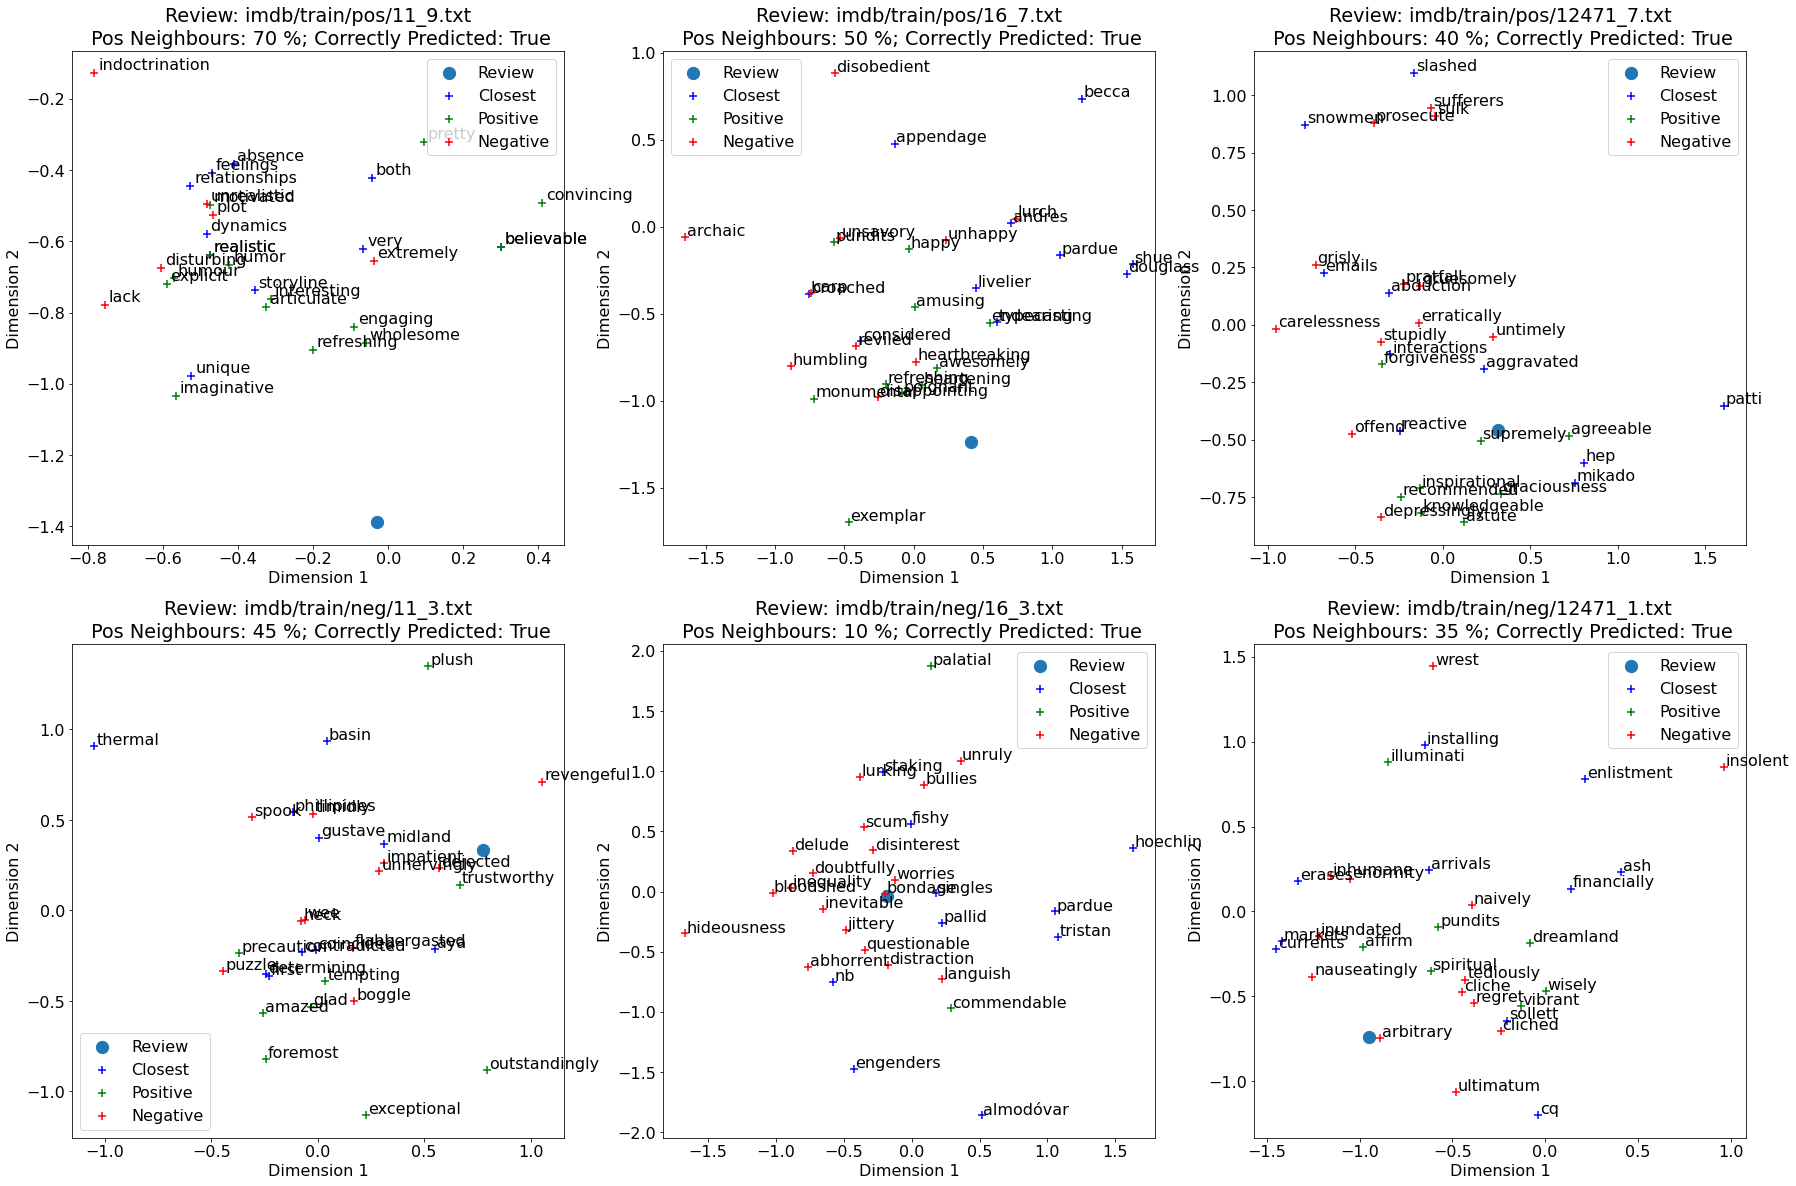

In [96]:
fig, ax = plt.subplots(2, 3, figsize=(30,20))

for i, vis_tuple in enumerate([(pos_visualisation_review_paths, pos_visualisation_review_gensim_inds), (neg_visualisation_review_paths, neg_visualisation_review_gensim_inds)]):
    visualisation_review_paths, visualisation_review_gensim_inds = vis_tuple

    for j, visualisation_review_path in enumerate(visualisation_review_paths):
        train_test_ind = visualisation_review_gensim_inds[i]
        review_pred_correct = imdb_predict_results[train_test_ind]

        review_embedding = gensim_sklearn.pipeline.named_steps['doc2vec'].transform([visualisation_review_path])
        review_embedding_pca = pca_embeds_2d.transform(review_embedding)

        review_closest_words = [w[0] for w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar(review_embedding, topn=1000)]
        review_closest_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in review_closest_words])[:10,:]
        review_closest_word_embeddings_pca = pca_embeds_2d.transform(review_closest_word_embeddings)

        review_closest_lexicon_words = [w for w in review_closest_words if w in [*lexicon_pos_words, *lexicon_neg_words]][:20]
        review_closest_lexicon_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in review_closest_lexicon_words])
        review_closest_lexicon_embeddings_pca = pca_embeds_2d.transform(review_closest_lexicon_embeddings)
        review_lexicon_labels = np.array([lexicon_dict[t][1] for t in review_closest_lexicon_words])

        ax[i,j].scatter(review_embedding_pca[:,0], review_embedding_pca[:,1], s=150, label='Review')

        ax[i,j].scatter(review_closest_word_embeddings_pca[:,0], review_closest_word_embeddings_pca[:,1], marker='+', s=75, c='b', label='Closest')
        for k in range(review_closest_word_embeddings_pca.shape[0]):
            ax[i,j].annotate(review_closest_words[k], (review_closest_word_embeddings_pca[k,0]+0.01, review_closest_word_embeddings_pca[k,1]+0.01))

        plt_colors = {'positive':'green', 'negative':'red', 'neutral':'blue', 'both':'yellow'}
        for k in plt_colors.items():
            k_ind = np.where(review_lexicon_labels == k[0])
            if np.any(k_ind):
                ax[i,j].scatter(review_closest_lexicon_embeddings_pca[k_ind,0], review_closest_lexicon_embeddings_pca[k_ind,1], marker='+', s=75, c=k[1], label=k[0].title())
        for k in range(review_closest_lexicon_embeddings_pca.shape[0]):
            ax[i,j].annotate(review_closest_lexicon_words[k], (review_closest_lexicon_embeddings_pca[k,0]+0.01, review_closest_lexicon_embeddings_pca[k,1]+0.01))

        ax[i,j].set_xlabel('Dimension 1')
        ax[i,j].set_ylabel('Dimension 2')
        ax[i,j].set_title(f'Review: {visualisation_review_path}\n Pos Neighbours: {int((review_lexicon_labels==SENTIMENTS.pos.lexicon_label).mean()*100)} %; Correctly Predicted: {review_pred_correct}')
        # ax[i,j].set_xlim(-1.25, 2)
        # ax[i,j].set_ylim(-1.25, 2)
        ax[i,j].legend()

In [148]:
# lexicon_pos_words_pca_3d = pca_embeds_3d.transform(np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in lexicon_pos_words if w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]))
# lexicon_neg_words_pca_3d = pca_embeds_3d.transform(np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in lexicon_neg_words if w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]))

# lexicon_pos_words_pca_df = pd.DataFrame(lexicon_pos_words_pca_3d)
# lexicon_pos_words_pca_df['sentiment'] = 'pos'

# lexicon_neg_words_pca_df = pd.DataFrame(lexicon_neg_words_pca_3d)
# lexicon_neg_words_pca_df['sentiment'] = 'neg'

# lexicon_pca_df = pd.concat((lexicon_pos_words_pca_df, lexicon_neg_words_pca_df))
# lexicon_pca_df['size'] = 0.8

# px.scatter_3d(lexicon_pca_df, x=0, y=1, z=2, color='sentiment', size='size')

## UMAP

In [187]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(gensim_vectors)

AttributeError: module 'umap' has no attribute 'UMAP'

In [ ]:
fig, ax = plt.subplots(1, figsize=(30,10))
ax.scatter(embedding[:,0], embedding[:,1])

### Pang et al words

In [ ]:
gensim_sklearn = GensimSVMSklearn(
    d2v_training_files=d2v_training_files,
    d2v_epochs=100,
    d2v_infer_epochs=50,
    d2v_min_count=5,
    d2v_vector_size=50,
    d2v_window=5,
    d2v_dm=0,
    d2v_dm_concat=0,
    d2v_dbow_words=1
)

In [ ]:
pang_positive_words = 'love wonderful best great superb still beautiful'.split()
pang_negative_words = 'bad worst stupid waste boring terrible awful'.split()

In [ ]:
pang_positive_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in pang_positive_words])
pang_negative_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in pang_negative_words])
pang_positive_word_embeddings.shape, pang_negative_word_embeddings.shape

In [ ]:
pang_positive_word_pca = pca_2.transform(pang_positive_word_embeddings)
pang_negative_word_pca = pca_2.transform(pang_negative_word_embeddings)

In [ ]:
pos_doc_ind = 10
neg_doc_ind = 10
pos_doc_pca = pca_2.transform(training_pos_embeddings[pos_doc_ind,:][None,:])[0]
neg_doc_pca = pca_2.transform(training_neg_embeddings[neg_doc_ind,:][None,:])[0]

In [ ]:
plt.scatter(pang_positive_word_pca[:,0], pang_positive_word_pca[:,1], marker='x', label='pos')
plt.scatter(pang_negative_word_pca[:,0], pang_negative_word_pca[:,1], marker='x', label='neg')
plt.scatter(pos_doc_pca[0], pos_doc_pca[1], marker='x', label='pos_doc')
plt.scatter(neg_doc_pca[0], neg_doc_pca[1], marker='x', label='neg_doc')
plt.legend()
for word, (x,y) in zip([*pang_positive_words, *pang_negative_words], np.vstack((pang_positive_word_pca, pang_negative_word_pca))):
    plt.text(x+0.05, y+0.05, word)